In [1]:
! pip install mplhep > /dev/null
! pip install zfit==0.16.0 > /dev/null

In [2]:
# Following https://stackoverflow.com/a/64604031
import sys
import time

from pathlib import Path

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[1] / "py")

if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
#! pip install zfit[nlopt] > /dev/null
! pip install seaborn > /dev/null
! pip install install numpy==1.22 > /dev/null

In [4]:
# Importing python libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import sys
from pathlib import Path
from matplotlib._api import check_in_list
import pickle
import os
import tensorflow as tf

2023-12-11 21:56:55.852151: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 21:56:55.897359: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 21:56:55.897650: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 21:56:56.639814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
import plot_tools
import zfit
import customPDFs
import SLSQPv2 as SLSQP_zfit

/home/carlos/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [6]:
# Relative path to get the samplers

path = './samplers/'

# Zfit configuration

In [7]:
# Setting the seed for zfit, to ensure equality of conditions
zfit.settings.set_seed(seed=42, numpy=True, backend=True)

In [8]:
# Parameter space for the cosine
cos = zfit.Space('cosThetaKMu', [-1,1])

In [9]:
cos_np = np.linspace(-1, 1, 1000)

In [10]:
# Setting the parameters with initial values
AFB = zfit.Parameter('AFB', 0)
FH = zfit.Parameter('FH', 0)

In [11]:
param_index = 0

In [12]:
# Sampler size of 100,000 events = 1e5
sampler_size = 1e5

In [13]:
# Creating the PDF with the selected parameters
decay_rate = customPDFs.decayWidth(AFB, FH, cos) # Crea una PDF del Base PDF de zfit

In [14]:
AFB_lst = [0, 0.25, -0.25, 0, -0.25, -0.7, 0.8]
FH_lst = [0, 0.5, 0.5, 1.5, 2.5, 1.5, 1.5]

In [15]:
# Creating a list of decay rates to store all the PDFs
decay_rate_lst = []

Text(1, 0, '$\\cos\\theta_{\\ell}$')

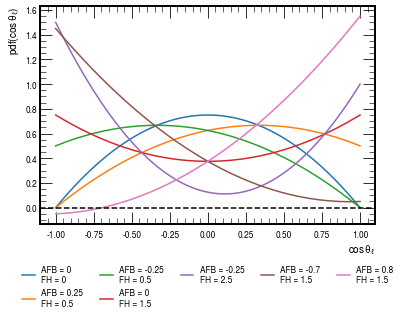

In [16]:
fig = plt.figure()
ax = plt.subplot(111)

for afb,fh in zip(AFB_lst, FH_lst):
    AFB.set_value(afb)
    FH.set_value(fh)
    decay_rate_lst.append(customPDFs.decayWidth(AFB, FH, cos))
    plt.plot(cos_np, decay_rate_lst[-1].pdf(cos_np), label=f'AFB = {afb}\nFH = {fh}')

AFB.set_value(0), FH.set_value(0)
#plt.plot(cos_np, decay_rate.pdf(cos_np), label=f'AFB = {0}\nFH = {0.02}', linewidth=5, color='black', ls='-')

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
plt.axhline(0, color='black', ls='--')
plt.ylabel(r'pdf($\cos\theta_{\ell}$)')
plt.xlabel(r'$\cos\theta_{\ell}$')

In [17]:
# Creating the sampler list
sampler_lst = []

In [18]:
AFB.set_value(AFB_lst[param_index])
FH.set_value(FH_lst[param_index])
dr = customPDFs.decayWidth(AFB, FH, cos)

(array([ 733., 2022., 3389., 4220., 5165., 5966., 6568., 7102., 7422.,
        7414., 7561., 7445., 6999., 6461., 5925., 5177., 4294., 3309.,
        2057.,  771.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <BarContainer object of 20 artists>)

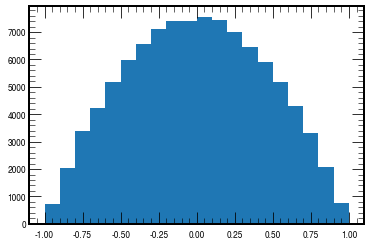

In [19]:
# Generating and saving the sampler
#dr = decay_rate_lst[2]

AFB_val = dr.params['AFB'].value().numpy()
FH_val = dr.params['FH'].value().numpy()

AFB.set_value(AFB_val), FH.set_value(FH_val)

filename = f'{path}drs_AFB_{AFB_val}_FH_{FH_val}.npy'

# The PDf doesn´t save the values of the parameters themselves
# AFB.set_value(decay_rate_lst[-1].params['AFB'].value().numpy())
# FH.set_value(decay_rate_lst[-1].params['FH'].value().numpy())

sampler = dr.create_sampler(sampler_size)

if os.path.exists(filename):
    #sampler_lst.append(sampler.from_numpy(cos, np.load(filename)))
    sampler = sampler.from_numpy(cos, np.load(filename))
else:
    sampler.resample()
    np.save(filename, sampler.numpy())
    #sampler_lst.append(sampler)
#print(sampler_lst[-1])
# 
plt.hist(sampler.numpy(), bins=20, range=[-1,1])

# Minimization

In [20]:
ftol_lst = [1e-2, 1e-4, 1e-6, 1e-8, 1e-10]

## Minuit

In [21]:
nll = zfit.loss.UnbinnedNLL(dr, sampler)

In [22]:
# Initial parameters

AFB.set_value(0.5)
FH.set_value(2.5)

In [23]:
# Creating a pandas dataframe to store results

result_df = pd.DataFrame(columns=['Minimizer', 'tol', 'AFB', 'hessAFB', 'FH', 'hessFH', 'time'])

In [24]:
index_count = 1

for ft in ftol_lst:

    AFB.set_value(AFB_lst[param_index])
    FH.set_value(FH_lst[param_index])
    dr = customPDFs.decayWidth(AFB, FH, cos)

    nll = zfit.loss.UnbinnedNLL(dr, sampler)

    AFB.set_value(0.5)
    FH.set_value(2.5)

    MIN = zfit.minimize.Minuit()
    
    # Minimization time =====================================
    start = time.time()
    # Minimization with zfit minuit
    minimum = MIN.minimize(nll)
    print(minimum)
    
    end = time.time()
    time_dif = end - start
    print("Minimization time with Minuit", time_dif)
    
    # Hessian error calculator time =========================
    start_h = time.time()
    
    minimum.hesse()
    
    end_h = time.time()
    print("Hessian error time with Minuit", end_h - start_h)
    
    result_df.loc[index_count] = ['Minuit 0.16.0', 
                         "{:.3g}".format(ft), 
                         round(minimum.params[AFB]['value'], 8),
                         round(minimum.hesse()[AFB]['error'],8),
                         round(minimum.params[FH]['value'], 8),
                         round(minimum.hesse()[FH]['error'],8),
                         time_dif] 
    index_count += 1

FitResult of
<UnbinnedNLL model=[<zfit.<class 'customPDFs.decayWidth'>  params=[AFB, FH]] data=[<zfit.core.data.Data object at 0x7fe97404d8e0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 2.2e-06 │              56836.08 |  9999.15 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
AFB             0.00101303       False
FH              0.00285174       False
Minimization time with Minuit 0.7570590972900391


/home/carlos/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1204: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")


Hessian error time with Minuit 0.2024073600769043
FitResult of
<UnbinnedNLL model=[<zfit.<class 'customPDFs.decayWidth'>  params=[AFB, FH]] data=[<zfit.core.data.Data object at 0x7fe97404d8e0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 2.2e-06 │              56836.08 |  9999.15 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
AFB             0.00101303       False
FH              0.00285174       False
Minimization time with Minuit 0.7059416770935059
Hessian error time with Minuit 0.2039327621459961
FitResult of
<UnbinnedNLL model=[<zfit.<

In [25]:
result_df

,Minimizer,tol,AFB,hessAFB,FH,hessFH,time
1,Minuit 0.16.0,0.01,0.001013,0.001234,0.002852,0.002753,0.757059
2,Minuit 0.16.0,0.0001,0.001013,0.001234,0.002852,0.002753,0.705942
3,Minuit 0.16.0,1e-06,0.001013,0.001234,0.002852,0.002753,0.692347
4,Minuit 0.16.0,1e-08,0.001013,0.001234,0.002852,0.002753,0.701164
5,Minuit 0.16.0,1e-10,0.001013,0.001234,0.002852,0.002753,0.724660


## SLSQPv2 minimization

In [26]:
dr.params

{'AFB': <zfit.Parameter 'AFB' floating=True value=0.001013>,
 'FH': <zfit.Parameter 'FH' floating=True value=0.002852>}

In [27]:
constraints = SLSQP_zfit.create_constraint(dr)

0 1


In [28]:
# Esto devolvía un error al correr en versiones anteriores
# El error indica lo siguiente:
# NotImplementedError: Cannot convert a symbolic Tensor (gradients/gradients/AddN_16/inputs_1_grad/sub:0) to a numpy array. 
# This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

# Solución encontrada en Stack Overflow:
# https://stackoverflow.com/questions/58479556/notimplementederror-cannot-convert-a-symbolic-tensor-2nd-target0-to-a-numpy

# numpy==1.19.5

# Minimization time for SLSQP_zfit =============================

index_count = 8

for ft in ftol_lst:

    AFB.set_value(AFB_lst[param_index])
    FH.set_value(FH_lst[param_index])
    dr = customPDFs.decayWidth(AFB, FH, cos)

    nll = zfit.loss.UnbinnedNLL(dr, sampler)

    AFB.set_value(0.5)
    FH.set_value(2.5)

    constraints = SLSQP_zfit.create_constraint(dr)
    
    print("===============================================================")
    print("===============================================================")
    print(f'\n                      ftol = {ft}                      \n')
    print("===============================================================")
    print("===============================================================")
    
    start = time.time()
    SLSQP = SLSQP_zfit.SLSQP(constraints=constraints, tol=ft)
    minimum = SLSQP.minimize(nll)
    print(minimum)
    
    end = time.time()

    time_dif = end - start
    
    # Hessian error calculation for SLSQP_zfit =====================
    print("Minimization time with SLSQP zfit", end - start)
    
    start = time.time()
    
    minimum.hesse()
    
    end = time.time()
    print("Hessian error time with SLSQP zfit", end - start)

    result_df.loc[index_count] = ['zfit 0.16.0', 
                         "{:.3g}".format(ft),  
                         round(minimum.params[AFB]['value'], 8),
                         round(minimum.hesse()[AFB]['error'],8),
                         round(minimum.params[FH]['value'], 8),
                         round(minimum.hesse()[FH]['error'],8),
                         time_dif] 

    index_count += 1

0 1

                      ftol = 0.01                      

FitResult of
<UnbinnedNLL model=[<zfit.<class 'customPDFs.decayWidth'>  params=[AFB, FH]] data=[<zfit.core.data.Data object at 0x7fe97404d8e0>] constraints=[]> 
with
<SLSQP SciPy SLSQP V2 tol=0.01>

╒═════════╤═════════════╤══════════════════╤════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 0.0012 │             56836.08 |  9999.151 │
╘═════════╧═════════════╧══════════════════╧════════╧══════════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
AFB              0.0010432       False
FH               0.0029424       False
Minimization time with SLSQP zfit 4.717982530593872
Hessian error time with SLSQP zfit 1.096472978591919
0 1

                

In [29]:
result_df

,Minimizer,tol,AFB,hessAFB,FH,hessFH,time
1,Minuit 0.16.0,0.01,0.001013,0.001234,0.002852,0.002753,0.757059
2,Minuit 0.16.0,0.0001,0.001013,0.001234,0.002852,0.002753,0.705942
3,Minuit 0.16.0,1e-06,0.001013,0.001234,0.002852,0.002753,0.692347
4,Minuit 0.16.0,1e-08,0.001013,0.001234,0.002852,0.002753,0.701164
5,Minuit 0.16.0,1e-10,0.001013,0.001234,0.002852,0.002753,0.724660
8,zfit 0.16.0,0.01,0.001043,0.001236,0.002942,0.002760,4.717983
9,zfit 0.16.0,0.0001,0.001011,0.001234,0.002856,0.002753,5.159660
10,zfit 0.16.0,1e-06,0.001011,0.001234,0.002856,0.002753,5.090296
11,zfit 0.16.0,1e-08,0.001011,0.001234,0.002856,0.002753,6.749246
12,zfit 0.16.0,1e-10,0.001011,0.001234,0.002856,0.002753,3.664001


## NLOpt

In [30]:
# index_count = 13

# for ft in ftol_lst:

#     AFB.set_value(AFB_lst[param_index])
#     FH.set_value(FH_lst[param_index])
#     dr = customPDFs.decayWidth(AFB, FH, cos)

#     nll = zfit.loss.UnbinnedNLL(dr, sampler)

#     AFB.set_value(0.5)
#     FH.set_value(2.5)

#     MIN = zfit.minimize.NLoptSLSQPV1()
    
#     # Minimization time =====================================
#     start = time.time()
#     # Minimization with zfit minuit
#     minimum = MIN.minimize(nll)
#     print(minimum)
    
#     end = time.time()
#     time_dif = end - start
#     print("Minimization time with NLOpt", time_dif)
    
#     # Hessian error calculator time =========================
#     start_h = time.time()
    
#     minimum.hesse()
    
#     end_h = time.time()
#     print("Hessian error time with NLOpt", end_h - start_h)
    
#     result_df.loc[index_count] = ['NLOpt', 
#                          "{:.3g}".format(ft), 
#                          round(minimum.params[AFB]['value'], 8),
#                          round(minimum.hesse()[AFB]['error'],8),
#                          round(minimum.params[FH]['value'], 8),
#                          round(minimum.hesse()[FH]['error'],8),
#                          time_dif] 
#     index_count += 1

In [31]:
# result_df

# Using simple constraints

In [32]:
# Simple constraint test

def custom_constraint_1():
    max_value = FH/2
    return tf.cond(tf.greater_equal(AFB, max_value), lambda: max_value, lambda: AFB)

def custom_constraint_2():
    min_value = FH/2
    return tf.cond(tf.less_equal(AFB, min_value), lambda: min_value, lambda: AFB)

def custom_constraint_3():
    max_value = np.float64(3.0)
    return tf.cond(tf.greater_equal(FH, max_value), lambda: max_value, lambda: FH)

In [42]:
simple_constraint_1 = zfit.constraint.SimpleConstraint(custom_constraint_1, params=AFB)
simple_constraint_2 = zfit.constraint.SimpleConstraint(custom_constraint_2, params=AFB)
simple_constraint_3 = zfit.constraint.SimpleConstraint(custom_constraint_3, params=FH)

## Zfit SLSQP minimization

In [43]:
print(AFB_lst[param_index])
print(FH_lst[param_index])

0
0


In [44]:
#param_index=6
tol = 1e-6

AFB.set_value(AFB_lst[param_index])
FH.set_value(FH_lst[param_index])
dr = customPDFs.decayWidth(AFB, FH, cos)

nll = zfit.loss.UnbinnedNLL(dr, sampler)

In [45]:
AFB.set_value(0.5)
FH.set_value(2.5)

#MIN = zfit.minimize.ScipySLSQPV1(tol)
MIN = zfit.minimize.Minuit(tol)

start = time.time()
minimum = MIN.minimize(nll)
print(minimum)

end = time.time()

time_dif = end - start

# Hessian error calculation for SLSQP_zfit =====================
print("Minimization time with SLSQP zfit", end - start)

# Estamos llegando a un mínimo FUERA de las constraints

FitResult of
<UnbinnedNLL model=[<zfit.<class 'customPDFs.decayWidth'>  params=[AFB, FH]] data=[<zfit.core.data.Data object at 0x7fe97404d8e0>] constraints=[]> 
with
<Minuit Minuit tol=1e-06>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 7.7e-09 │              56836.08 |  9999.15 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
AFB             0.00101149       False
FH              0.00285559       False
Minimization time with SLSQP zfit 0.8030188083648682


In [48]:
AFB.set_value(0.5)
FH.set_value(2.5)

MIN = zfit.minimize.ScipySLSQPV1()


In [49]:
dir(MIN)

['_DEFAULTS',
 '_VALID_SCIPY_GRADIENT',
 '_VALID_SCIPY_HESSIAN',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_derivative_methods',
 '_call_minimize',
 '_check_convert_input',
 '_filter_floating_params',
 '_internal_maxiter',
 '_internal_tol',
 '_is_stateful',
 '_make_stateful',
 '_minimize',
 '_minimize_func',
 '_n_iter_per_param',
 '_nrandom_max',
 '_recover_result',
 '_scipy_initializer',
 '_scipy_verbosity_setter',
 '_state',
 '_strategy',
 '_subclass_check_support',
 '_tol',
 '_update_tol_inplace',
 'copy',
 'create_criterion',
 'create_evaluator',
 'criterion',
 'get_maxiter',
 'maxiter',
 'minimize',
 '

In [50]:
MIN._add_derivative_methods(gradient=['2-point', '3-point',
                                               # 'cs',  # works badly
                                               None, True, False, 'zfit'])

In [51]:
AFB.set_value(0.5)
FH.set_value(2.5)

MIN = zfit.minimize.ScipySLSQPV1()

start = time.time()
minimum = MIN.minimize(nll)
print(minimum)

end = time.time()

time_dif = end - start

# Hessian error calculation for SLSQP_zfit =====================
print("Minimization time with SLSQP zfit", end - start)

# Estamos llegando a un mínimo FUERA de las constraints

/home/carlos/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/carlos/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/carlos/.local/lib/python3.8/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/home/carlos/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/carlos/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/carlos/.local/lib/python3.8/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice enco

KeyboardInterrupt: 

In [52]:
MIN = zfit.minimize.NLoptSLSQPV1(tol)

start = time.time()
minimum = MIN.minimize(nll)
print(minimum)

end = time.time()

time_dif = end - start

# Hessian error calculation for SLSQP_zfit =====================
print("Minimization time with SLSQP zfit", end - start)

# Estamos llegando a un mínimo FUERA de las constraints

/home/carlos/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/carlos/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/carlos/.local/lib/python3.8/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/home/carlos/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/carlos/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/carlos/.local/lib/python3.8/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice enco

KeyboardInterrupt: 

In [53]:
# Agregando las constraints al NLL

nll.add_constraints(simple_constraint_1)
nll.add_constraints(simple_constraint_2)
nll.add_constraints(simple_constraint_3)

In [54]:
AFB.set_value(0.5)
FH.set_value(2.5)

#MIN = zfit.minimize.ScipySLSQPV1(tol)
MIN = zfit.minimize.Minuit(tol)

start = time.time()
minimum = MIN.minimize(nll)
print(minimum)

end = time.time()

time_dif = end - start

# Hessian error calculation for SLSQP_zfit =====================
print("Minimization time with SLSQP zfit", end - start)

# Estamos llegando a un mínimo FUERA de las constraints

FitResult of
<UnbinnedNLL model=[<zfit.<class 'customPDFs.decayWidth'>  params=[AFB, FH]] data=[<zfit.core.data.Data object at 0x7fe97404d8e0>] constraints=[<zfit.core.constraint.SimpleConstraint object at 0x7fe9790283a0>, <zfit.core.constraint.SimpleConstraint object at 0x7fe9743ea0d0>, <zfit.core.constraint.SimpleConstraint object at 0x7fe979028370>]> 
with
<Minuit Minuit tol=1e-06>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 7.7e-09 │             56836.08 |  9999.155 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
AFB             0.00100935       False
FH               0.0028438      

In [55]:
nll.constraints[2].params

{'param_0': <zfit.Parameter 'FH' floating=True value=0.002844>}

In [56]:
# param_index=6
#tol = 1e-4

# AFB.set_value(AFB_lst[param_index])
# FH.set_value(FH_lst[param_index])
# dr = customPDFs.decayWidth(AFB, FH, cos)

# nll = zfit.loss.UnbinnedNLL(dr, sampler)

In [57]:
AFB.set_value(0.5)
FH.set_value(2.5)

MIN = zfit.minimize.ScipySLSQPV1(tol)
#MIN = zfit.minimize.Minuit(tol)

start = time.time()
minimum = MIN.minimize(nll)
print(minimum)

end = time.time()

time_dif = end - start

# Hessian error calculation for SLSQP_zfit =====================
print("Minimization time with SLSQP zfit", end - start)

# Estamos llegando a un mínimo FUERA de las constraints

/home/carlos/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/carlos/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/carlos/.local/lib/python3.8/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/home/carlos/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/carlos/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/carlos/.local/lib/python3.8/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice enco

KeyboardInterrupt: 

In [58]:
AFB.set_value(0.5)
FH.set_value(2.5)

MIN = zfit.minimize.NLoptSLSQPV1(tol)
#MIN = zfit.minimize.Minuit(tol)

start = time.time()
minimum = MIN.minimize(nll)
print(minimum)

end = time.time()

time_dif = end - start

# Hessian error calculation for SLSQP_zfit =====================
print("Minimization time with SLSQP zfit", end - start)

# Estamos llegando a un mínimo FUERA de las constraints

FitResult of
<UnbinnedNLL model=[<zfit.<class 'customPDFs.decayWidth'>  params=[AFB, FH]] data=[<zfit.core.data.Data object at 0x7fe97404d8e0>] constraints=[<zfit.core.constraint.SimpleConstraint object at 0x7fe9790283a0>, <zfit.core.constraint.SimpleConstraint object at 0x7fe9743ea0d0>, <zfit.core.constraint.SimpleConstraint object at 0x7fe979028370>]> 
with
<NLoptSLSQPV1 NLopt SLSQP tol=1e-06>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  False  │    False    │      False       │ 2.3e+04 │            144522.00 |  97685.11 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
AFB                    0.5       False
FH                   